# Diabetes Classification for County Health Department

<img src="images/diabetes.jpeg" alt="Drawing" style="width: 1000px;height:300px;float: left;"/>

## Overview
This project uses machine learning classification algorithms to predict whether a person has diabetes, as well as determine what are some of the most important features related to diabetes. A XGBoost model built using CDC survey data from 2015 predicts whether a person has diabetes with a 75% accuracy and 80% recall. The model determined general health, blood pressure, and BMI to be the most important features in predicting diabetes. This information can be used to inform guidance for future public health efforts.

## Business Understanding
The local health department wants to address the prevalence of diabetes in their community. A classification model for diabetes can predict which people are at risk as well as identify key risk factors that can be addressed with targeted health interventions.

## Data Understanding
This project uses 2015 survey data from the CDC's Behavioral Risk Factor Surveillance System. The dataset contains information about the health and lifestyle of 72,692 people. The target variable in this dataset is a binary with values of 1 meaning a person is pre-diabetic or diabetic and 0 meaning they are not pre-diabetic or diabetic.

In [1]:
#import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.feature_selection import RFE, RFECV
import shap
from sklearn.metrics import accuracy_score, recall_score
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
import matplotlib.ticker as mtick

In [2]:
#import dataset and preview
df = pd.read_csv('data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

In [4]:
df.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,...,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,0.500000,0.563458,0.525703,0.975259,29.856985,0.475273,0.062171,0.147810,0.703036,0.611795,...,0.954960,0.093914,2.837082,3.752037,5.810417,0.252730,0.456997,8.584055,4.920953,5.698311
std,0.500004,0.495960,0.499342,0.155336,7.113954,0.499392,0.241468,0.354914,0.456924,0.487345,...,0.207394,0.291712,1.113565,8.155627,10.062261,0.434581,0.498151,2.852153,1.029081,2.175196
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,7.000000,4.000000,4.000000
50%,0.500000,1.000000,1.000000,1.000000,29.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,9.000000,5.000000,6.000000
75%,1.000000,1.000000,1.000000,1.000000,33.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,4.000000,2.000000,6.000000,1.000000,1.000000,11.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


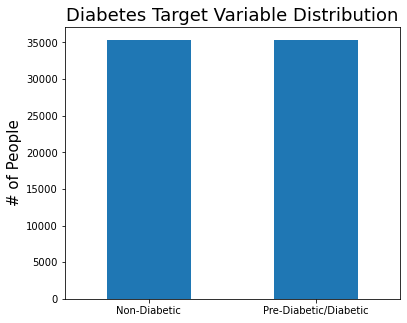

In [5]:
#class imbalance
fig, ax = plt.subplots(figsize=(6, 5))
df.Diabetes_binary.value_counts().plot.bar(ax=ax);
ax.set_title('Diabetes Target Variable Distribution', fontsize=18);
ax.set_ylabel('# of People', fontsize=15);
ax.set_xticklabels(['Non-Diabetic', 'Pre-Diabetic/Diabetic'], rotation=0);

## Data Preparation
Despite all the data being in numeric form, several features are actually categorical variables that need to be converted into dummy variables before modeling.

In [6]:
#convert categorical variables into dummy variables
categoricals = ['Education', 'Income']
categorical_df = df[categoricals].astype("category")
dummies = pd.get_dummies(categorical_df , drop_first=True)

In [7]:
#drop original categorical features from df and concat with dummy variables
df.drop(categoricals, axis=1, inplace=True)
df = pd.concat([df, dummies], axis=1)

In [8]:
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,Education_4.0,Education_5.0,Education_6.0,Income_2.0,Income_3.0,Income_4.0,Income_5.0,Income_6.0,Income_7.0,Income_8.0
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,1
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,0,0,1,0,0,0,0,0,0,1
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,0,0,1,0,0,0,0,0,0,1
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,0,0,1,0,0,0,0,0,0,1
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,0,1,0,0,0,0,0,0,0,1


In [9]:
#Split the data into target(y) and predictor(X) variables
y = df['Diabetes_binary']
X = df.drop('Diabetes_binary', axis=1)

#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [10]:
#scale data using StandardScaler transformer
scaler = StandardScaler()
scaler.fit(X_train)

#convert scaled data back into datframes
X_train_scaled = pd.DataFrame(scaler.transform(X_train), 
                              columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                             columns=X_test.columns)

## Classification Modeling
To predict the binary diabetes target value, I will use a classification algorithm. I will iterate through multiple algorithms to determine the optimal model based on accuracy and recall.

### Logitic Regression

In [11]:
#funtion that displays model results
def average_scores(results):
    average_scores = {}
    for key, value in results.items():
        print(key+':', np.mean(value))

In [24]:
#instantiate baseline logistic regression model
logreg_baseline = LogisticRegression(fit_intercept=False)

#run cross_validation
logreg_baseline_results  = cross_validate(logreg_baseline,
                                          X_train_scaled, y_train,
                                          scoring=('accuracy', 'recall'),
                                          return_train_score=True)

#print scores
average_scores(logreg_baseline_results)

fit_time: 0.070166015625
score_time: 0.00808711051940918
test_accuracy: 0.7482035770393447
train_accuracy: 0.7487221608548714
test_recall: 0.7761222180309317
train_recall: 0.7767823462844209


#### Hyperparameter Tuning

In [25]:
#define parameter grid for search
logreg_param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
                    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
                    'max_iter': [10000]}

#instantiate grid search
#refit based on recall
logreg_grid = GridSearchCV(estimator=logreg_baseline,
                           param_grid=logreg_param_grid,
                           scoring=['accuracy', 'recall'],
                           refit='recall',
                           cv=3,
                           n_jobs=1,
                           return_train_score=True)

#fit to training data
logreg_grid.fit(X_train_scaled, y_train)

#print the optimal parameters
best_parameters = logreg_grid.best_params_
print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
C: 0.01
max_iter: 10000
solver: 'newton-cg'


In [26]:
#indtantiate tuned logistic regression
logreg_tuned = LogisticRegression(C=0.1, solver='newton-cg',
                                  max_iter=10000,
                                  fit_intercept=False)

#run cross_validation
logreg_tuned_results  = cross_validate(logreg_tuned,
                                       X_train_scaled,
                                       y_train,
                                       scoring=('accuracy', 'recall'),
                                       return_train_score=True)
#print scores
average_scores(logreg_tuned_results)

fit_time: 0.229046630859375
score_time: 0.008140993118286134
test_accuracy: 0.7482035788181626
train_accuracy: 0.7487598835810392
test_recall: 0.7760844964164466
train_recall: 0.7768106374952847


The hyperparameter tuning made little difference, increasing the recall score by only 0.001.

### Random Forest

In [27]:
#instantiate random forest classifier
rf_baseline = RandomForestClassifier()

#run cross_validation
rf_baseline_results  = cross_validate(rf_baseline,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'recall'),
                                      return_train_score=True)

In [60]:
average_scores(rf_baseline_results)

fit_time: 3.1875038623809813
score_time: 0.2239957332611084
test_accuracy: 0.7361889030716025
train_accuracy: 0.9959259888183405
test_recall: 0.7733685401735194
train_recall: 0.994511505092418


While the test accuracy and recall are similar to the logistic regression model, the test metrics differ substantially from the training scores indicating that the current model is overfitting to the training data.

#### Hyperparameter Tuning

In [ ]:
#define parameter grid for search
rf_param_grid = {'max_depth': [5, 10, 25, 50, None],
 'max_features': ['auto', 5],
 'min_samples_leaf': [1, 2, 4]}

In [29]:
#define parameter grid for search
rf_param_grid = {'max_depth': [5, 10, 25, 50, None],
 'max_features': ['auto', 5],
 'min_samples_leaf': [1, 2, 4]}

#insantiate and fit search object
grid_rf = GridSearchCV(rf_baseline, 
                       rf_param_grid,
                       scoring=['accuracy', 'recall'],
                       cv=3, n_jobs=1,
                       refit='recall',
                       return_train_score=True)

grid_rf.fit(X_train, y_train)

#print best parameters
best_parameters = grid_rf.best_params_
print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
max_depth: 10
max_features: 5
min_samples_leaf: 2


In [34]:
#instantiate tuned random forest classifier
rf_tuned = RandomForestClassifier(max_depth=10,
                                  max_features=5,
                                  min_samples_leaf=2)

#run cross_validation
rf_tuned_results  = cross_validate(rf_tuned,
                                   X_train,
                                   y_train,
                                   scoring=('accuracy', 'recall'),
                                   return_train_score=True)

In [35]:
average_scores(rf_tuned_results)

fit_time: 1.812109613418579
score_time: 0.1258373737335205
test_accuracy: 0.7492220659668962
train_accuracy: 0.7722467439149717
test_recall: 0.7883440211241041
train_recall: 0.8104205960015088


The random forest model with tuned parameters did show an improvement in accuracy and recall as well as a reduction in the over-fitting present in the baseline model.

### XGBoost

In [65]:
#instantiate a baseline XGBoost Classifier
xgb_baseline = XGBClassifier()

#run cross-validation
xgb_baseline_results  = cross_validate(xgb_baseline,
                                       X_train,
                                       y_train,
                                       scoring=('accuracy', 'recall'),
                                       return_train_score=True)

In [66]:
average_scores(xgb_baseline_results)

fit_time: 0.8246486186981201
score_time: 0.028898859024047853
test_accuracy: 0.7472038884392235
train_accuracy: 0.7985863548162737
test_recall: 0.7879668049792531
train_recall: 0.8371463598642022


The XGBoost baseline model has similar accuracy and recall to the random forest tuned classifier.

#### Hyperparameter Tuning

In [17]:
#define parameter grid for search
xgb_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

#insantiate and fit search object
grid_xgb = GridSearchCV(xgb,
                        xgb_param_grid,
                        scoring=['accuracy', 'recall'],
                        cv=3, n_jobs=1,
                        refit='recall',
                        return_train_score=True)

grid_xgb.fit(X_train, y_train)

#print best parameters
best_parameters = grid_xgb.best_params_
print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 0.7


In [12]:
#instantiate tuned XGBoost Classifier
xgb_tuned = XGBClassifier(learning_rate=0.1,
                         max_depth=5,
                         min_child_weight=1,
                         n_estimators=100,
                         subsample=0.7)

#run cross-validation
xgb_tuned_results  = cross_validate(xgb_tuned,
                                    X_train,
                                    y_train,
                                    scoring=('accuracy', 'recall'),
                                    return_train_score=True)

In [13]:
average_scores(xgb_tuned_results)

fit_time: 1.0026754856109619
score_time: 0.026635217666625976
test_accuracy: 0.753673332099308
train_accuracy: 0.7660037029925563
test_recall: 0.7960769520935497
train_recall: 0.809807619766126


The XGBoost tuned model has the highest accuracy and recall of any of the classification models.

### Feature Selection
I run a recursive feature elimantion to see if running the xgboost model on a subset of features improves the accuracy or recall

In [14]:
#instatiate and fit RFECV object with xgb tuned model
selector = RFECV(xgb_tuned,cv=5)
selector = selector.fit(X_train, y_train)

In [15]:
#show which features were eliminated
for i in range(len(X_train.columns)):
    print(X_train.columns[i],':', selector.support_[i])

HighBP : True
HighChol : True
CholCheck : True
BMI : True
Smoker : True
Stroke : True
HeartDiseaseorAttack : True
PhysActivity : True
Fruits : True
Veggies : True
HvyAlcoholConsump : True
AnyHealthcare : True
NoDocbcCost : True
GenHlth : True
MentHlth : True
PhysHlth : True
DiffWalk : True
Sex : True
Age : True
Education_2.0 : True
Education_3.0 : True
Education_4.0 : True
Education_5.0 : True
Education_6.0 : True
Income_2.0 : True
Income_3.0 : True
Income_4.0 : True
Income_5.0 : True
Income_6.0 : True
Income_7.0 : True
Income_8.0 : True


In [16]:
#reduce x_train to selected features
selected_cols = selector.get_support(indices=True)
X_train_selected = X_train.iloc[:, selected_cols]

In [17]:
#instantiate selected XGBoost Classifier
xgb_selected = XGBClassifier(learning_rate=0.1,
                         max_depth=5,
                         min_child_weight=1,
                         n_estimators=100,
                         subsample=0.7)

#run cross-validation
xgb_selected_results  = cross_validate(xgb_selected,
                                       X_train_selected,
                                       y_train,
                                       scoring=('accuracy', 'recall'),
                                       return_train_score=True)

In [18]:
average_scores(xgb_selected_results)

fit_time: 0.995989465713501
score_time: 0.021869802474975587
test_accuracy: 0.753673332099308
train_accuracy: 0.7660037029925563
test_recall: 0.7960769520935497
train_recall: 0.809807619766126


This XGBoost model with a subset of features has a small imporvemnt in accuracy and recall over the previous tuned XGBoost model.

## Final Model Evaluation
The XGBoost tuned and selected model performed best in both accuracy and recall and thus the final model. Now I conduct a final evaluation using the test set data.

In [19]:
X_final = X_train_selected
y_final = y_train

final_model = xgb_selected
final_model.fit(X_final, y_final)

X_test_selected = X_test.iloc[:, selected_cols]
y_pred_test = final_model.predict(X_test_selected)
y_pred_train = final_model.predict(X_train_selected)


print("Test Accuracy: ", accuracy_score(y_test, y_pred_test))
print("Train Accuracy: ", accuracy_score(y_train, y_pred_train))
print("Test Recall: ", recall_score(y_test, y_pred_test))
print("Train Recall: ", recall_score(y_train, y_pred_train))

Test Accuracy:  0.7551632433655859
Train Accuracy:  0.7636696278692544
Test Recall:  0.8048890900860117
Train Recall:  0.8079969822708412


In [20]:
# explain the model's feature effects using shap values
explainer = shap.Explainer(final_model)
shap_values = explainer(X_final)

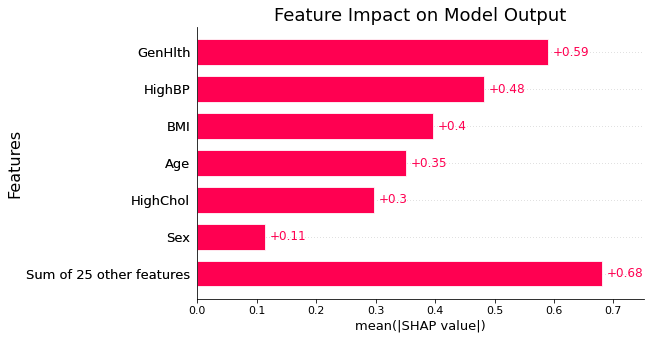

In [21]:
#plot the average shap values for each feature
shap.plots.bar(shap_values, max_display=7, show=False)
plt.title('Feature Impact on Model Output', fontsize=18);
plt.ylabel('Features', fontsize=16)
plt.show();

The final model uses an xgboost algorithm and has an accuracy of 76%. It also has a recall of 80%, meaning that for someone who has diabetes there is an 80% chance the model will classify them as diabetic. The final model includes 27 total features. According to the final model, the three most important features realted to diabetes are poor general health, high blood pressure, and high BMI. General health has the greatest impact with a mean shap value of 0.59, followed by high blood pressure at 0.48, and BMI at 0.40.

### Further Evaluation
I will now look at some of the most imortant features more closely.

#### General Health

In [323]:
#group the data by genhlth and diabetes_binary
gen_hlth_grouped = df.groupby(['GenHlth', 'Diabetes_binary']).size().unstack()

#reset index
gen_hlth_grouped.reset_index(inplace=True)

In [324]:
#add a "percent diabetic" feature to the df and sort by it
gen_hlth_grouped['Percent_Diabetic'] = (gen_hlth_grouped[1] / 
                                        (gen_hlth_grouped[0] + 
                                         gen_hlth_grouped[1])*100)
gen_hlth_grouped.sort_values('Percent_Diabetic', inplace=True, 
                             ascending=False)
gen_hlth_grouped

Diabetes_binary,GenHlth,0.0,1.0,Percent_Diabetic
4,5.0,1230,4578,78.822314
3,4.0,3513,9790,73.592423
2,3.0,9970,13457,57.442267
1,2.0,13491,6381,32.110507
0,1.0,7142,1140,13.764791


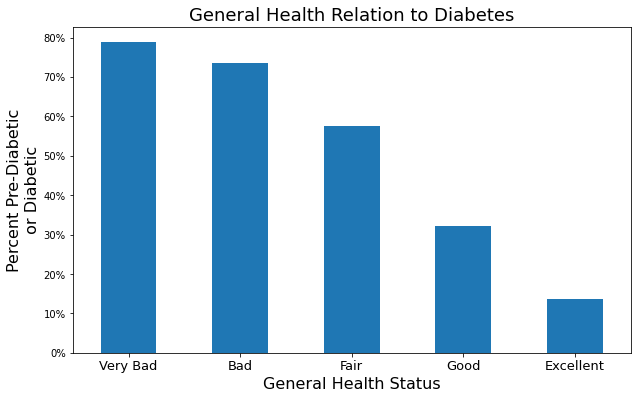

In [310]:
#setup figure size
fig, ax = plt.subplots(figsize=(10, 6))

#bar plot gen health vs percent diabetic
gen_hlth_grouped.plot.bar(ax=ax, x='GenHlth', y='Percent_Diabetic');
ax.set_xticklabels(['Very Bad', 'Bad', 'Fair', 'Good', 'Excellent'], 
                   rotation=0, fontsize=13);
ax.get_legend().remove()
ax.set_title('General Health Relation to Diabetes', fontsize=18)
ax.set_xlabel('General Health Status', fontsize=16)
ax.set_ylabel('Percent Pre-Diabetic\n or Diabetic ', fontsize=16)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

#### High Blood Pressure

In [311]:
#group df by high bp and diabetes binary
bp_grouped = df.groupby(['HighBP', 'Diabetes_binary']).size().unstack()
bp_grouped.reset_index(inplace=True)

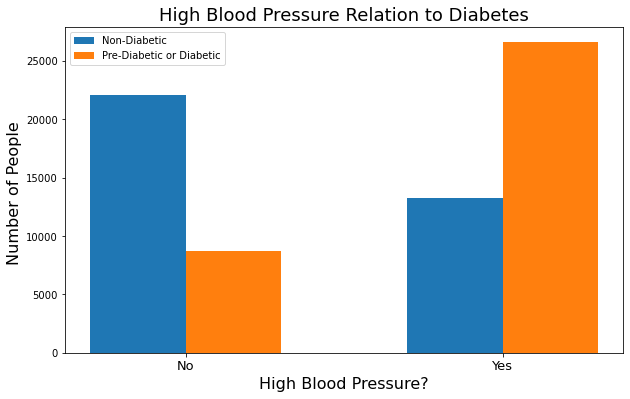

In [312]:
#setup figure for high BP vs # of people
fig, ax = plt.subplots(figsize=(10, 6))

#set-axis
x = np.array([0, 1])
#plot non-diabetic data
ax.bar(x=x-0.15, height=bp_grouped[0], width=0.3,
       label='Non-Diabetic');
#plot per/diabetic data
ax.bar(x=x+0.15, height=bp_grouped[1], width=0.3, 
       label='Pre-Diabetic or Diabetic');
ax.set_xticks([0, 1]);
ax.set_xticklabels(['No', 'Yes'], fontsize=13)
ax.set_title('High Blood Pressure Relation to Diabetes', fontsize=18);
ax.set_xlabel('High Blood Pressure?', fontsize=16);
ax.set_ylabel('Number of People ', fontsize=16);
ax.legend();

#### BMI

In [313]:
#group by diabtes and take mean
bmi_grouped = df.groupby('Diabetes_binary').mean()
bmi_grouped.reset_index(inplace=True)

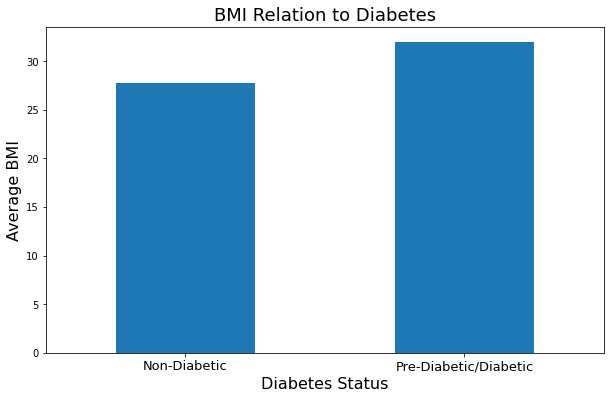

In [314]:
#setup figure
fig, ax = plt.subplots(figsize=(10, 6))

#plot diabetic_bianry vs avergae BMI
bmi_grouped.plot.bar(ax=ax, x='Diabetes_binary', y='BMI');
ax.set_xticklabels(['Non-Diabetic', 'Pre-Diabetic/Diabetic'],
                   rotation=0, fontsize=13);
ax.get_legend().remove()
ax.set_title('BMI Relation to Diabetes', fontsize=18);
ax.set_xlabel('Diabetes Status', fontsize=16);
ax.set_ylabel('Average BMI', fontsize=16);

## Conclusions

- **Provide the survey online for community members to complete:** For those whom the model predicts to be pre-diabetic or diabetic, a recommendation to see a doctor for further testing should be given.
- **Educate the community of the link between general health and diabetes:** Some people may be under the assumption that diabetes is solely determined by genetics and are therefore not a risk if they do not have a family history of the disease. Increasing awareness that diabetes is linked with general health can help prevent the development of the disease.
- **Provide specific dietary and lifestyle steps the community can take to reduce blood pressure and lose weight:** high blood pressure and high BMI are key risk factors in diabetes. Knowing how to lower these to metrics is essential to reducing their prevalence in the community.
- **Invest in programs that increase access to healthier foods:** In addition to providing health advice, ensuring access to resources for the community to follow such advice is critical.

## Next Steps

- **Search for additional survey data to be included in the model to improve accuracy and recall:** the current model incorrectly classifies 24% of survey responses
- **Conduct analysis of how different diets impact diabetes:** the current features included in the model are primarily about general health conditions. Specific information about what types of foods are correlated with diabetes can be beneficial in preventing disease.
- **Analyze the relationship between environmental factors and diabetes:** this model includes primarily health and lifestyle factors. Environmental factors such as housing or pollution levels may also be indicators of diabetes.